# Tuning Random Forest model and error analysis

## Albina Jetybayeva. DSE511

As it was observed, Random Forest provides higher evaluation parameters (accuracy, precision and f1score and especially recall) compared to Logistic Regression and KNN. Although it is significantly slower, the focus was on getting the highest most important parameter Recall, which decreases the false negatives. Random Forest works well, since a large number of relatively uncorrelated models (trees) operating as a committee usually outperform any of the individual constituent models. So in this part RandomForest hyperparameters will be investigated and basic error analysis will be done.

In [1]:
#Import the basic important libraries
import numpy as np
import pandas as pd

In [2]:
#Extract data from the file:
data = pd.read_csv('train.csv')
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
print('There are {} rows and {} columns in train'.format(data.shape[0],data.shape[1]))

There are 7613 rows and 5 columns in train


In [4]:
# drop id, keyword, and location columns for train datasets as only tweet text will be used
cols_to_drop = ["id", "keyword", "location"]
data_train = data.drop(cols_to_drop, axis=1)

data_train.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
#First, basic preprocessing will be donw with the removal of hyperlinks, punctuation, non-ascii, numbers

import re
import string
def preprocess(text):

    text=text.lower()
    # remove hyperlinks
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'http?:\/\/.*[\r\n]*', '', text)
    #Replace &amp, &lt, &gt with &,<,> respectively
    text=text.replace(r'&amp;?',r'and')
    text=text.replace(r'&lt;',r'<')
    text=text.replace(r'&gt;',r'>')
    #remove mentions
    text = re.sub(r"(?:\@)\w+", '', text)
    #remove non ascii chars
    text=text.encode("ascii",errors="ignore").decode()
    #remove some puncts (except . ! ?)
    text=re.sub(r'[:"#$%&\*+,-/:;<=>@\\^_`{|}~]+','',text)
    text=re.sub(r"'","",text)
    text=re.sub(r"\(","",text)
    text=re.sub(r"\)","",text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # remove numbers
    text=re.sub(r'\d+', '', text)
    text=" ".join(text.split())
    return text
data1=data_train
data1['text'] = data1['text'].apply(preprocess)
data_processed = data1[data1["text"]!=''] #removes empty rows of text
data_processed.head()
data_processed


,text,target
0,our deeds are the reason of this earthquake ma...,1
1,forest fire near la ronge sask canada,1
2,all residents asked to shelter in place are be...,1
3,people receive wildfires evacuation orders in ...,1
4,just got sent this photo from ruby alaska as s...,1
...,...,...
7608,two giant cranes holding a bridge collapse int...,1
7609,the out of control wild fires in california ev...,1
7610,m utckm s of volcano hawaii,1
7611,police investigating after an ebike collided w...,1


In [6]:
#Split the data first and do all feature transformations after the test_train splitting on the train set only to avoid data leakage

from sklearn.model_selection import train_test_split
X = data_processed[["text"]] # Features
y = data_processed[["target"]] #Labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

print("Training Data", len(y_train))
print("Testing Data", len(y_test))


Training Data 6804
Testing Data 757


In [7]:
#Import libraries for stopwords

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
#Apply stopwords removal to X_train

stop = stopwords.words('english')
X_train['tweet_without_stopwords'] = X_train['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
X_train

<ipython-input-8-4e90c604de51>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['tweet_without_stopwords'] = X_train['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))


,text,tweet_without_stopwords
5319,breaking th death confirmed in legionnaires ou...,breaking th death confirmed legionnaires outbr...
5793,people arent rioting because justice has been ...,people arent rioting justice served murderer b...
4503,hurricane stm quem lembra,hurricane stm quem lembra
7394,my fifty online dates and why im still single ...,fifty online dates im still single michael win...
226,day of tryouts went good minus the fact i stop...,day tryouts went good minus fact stopped quick...
...,...,...
916,ive just watched episode se of bloody monday,ive watched episode se bloody monday
5228,the removal of all traces of something obliter...,removal traces something obliteration
4009,etp bengal floods cm mamata banerjee blames dv...,etp bengal floods cm mamata banerjee blames dv...
243,hell is just a fraction of his belief of total...,hell fraction belief total annihilation destru...


In [9]:
#Apply stopwords removal to X_test

stop = stopwords.words('english')
X_test['tweet_without_stopwords'] = X_test['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
X_test

<ipython-input-9-58a53dedcafc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['tweet_without_stopwords'] = X_test['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))


,text,tweet_without_stopwords
1763,tells of the tragic midmorning collision which...,tells tragic midmorning collision claimed life...
834,a blizzard would be clutch asf,blizzard would clutch asf
6756,im a tornado looking for a soul to take,im tornado looking soul take
5338,world class tgirl ass scene pandemonium,world class tgirl ass scene pandemonium
5731,video were picking up bodies from water rescue...,video picking bodies water rescuers searching ...
...,...,...
561,do your own thing the battle of internal vs ex...,thing battle internal vs external motivation
6773,hey lets challenge then to a tornado tag tlc m...,hey lets challenge tornado tag tlc match winne...
7112,dramatic video shows plane landing during viol...,dramatic video shows plane landing violent storm
2357,dont think they will paint the lab building ca...,dont think paint lab building cause planning d...


In [10]:
#Import lemmatizing libraries

nltk.download('wordnet')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

#Apply lemmatizing function to X_train 

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

X_train['text_lemmatized'] = X_train.tweet_without_stopwords.apply(lemmatize_text)
X_train['text_lemmatized'] = X_train['text_lemmatized'].apply(lambda x: " ".join(x)) #convert list to one string

X_train


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
<ipython-input-10-626b60ce2b33>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['text_lemmatized'] = X_train.tweet_without_stopwords.apply(lemmatize_text)
<ipython-input-10-626b60ce2b33>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['text_lemmatized'] = X_train['text_lemmatized'].apply(lambda x: " ".join(x)) #convert list to one string

,text,tweet_without_stopwords,text_lemmatized
5319,breaking th death confirmed in legionnaires ou...,breaking th death confirmed legionnaires outbr...,breaking th death confirmed legionnaire outbre...
5793,people arent rioting because justice has been ...,people arent rioting justice served murderer b...,people arent rioting justice served murderer b...
4503,hurricane stm quem lembra,hurricane stm quem lembra,hurricane stm quem lembra
7394,my fifty online dates and why im still single ...,fifty online dates im still single michael win...,fifty online date im still single michael wind...
226,day of tryouts went good minus the fact i stop...,day tryouts went good minus fact stopped quick...,day tryout went good minus fact stopped quickl...
...,...,...,...
916,ive just watched episode se of bloody monday,ive watched episode se bloody monday,ive watched episode se bloody monday
5228,the removal of all traces of something obliter...,removal traces something obliteration,removal trace something obliteration
4009,etp bengal floods cm mamata banerjee blames dv...,etp bengal floods cm mamata banerjee blames dv...,etp bengal flood cm mamata banerjee blame dvc ...
243,hell is just a fraction of his belief of total...,hell fraction belief total annihilation destru...,hell fraction belief total annihilation destru...


In [11]:
#Apply lemmatizing function to X_test

X_test['text_lemmatized'] = X_test.tweet_without_stopwords.apply(lemmatize_text)
X_test['text_lemmatized'] = X_test['text_lemmatized'].apply(lambda x: " ".join(x)) #convert list to one string

X_test

<ipython-input-11-a578afb630d0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['text_lemmatized'] = X_test.tweet_without_stopwords.apply(lemmatize_text)
<ipython-input-11-a578afb630d0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['text_lemmatized'] = X_test['text_lemmatized'].apply(lambda x: " ".join(x)) #convert list to one string


,text,tweet_without_stopwords,text_lemmatized
1763,tells of the tragic midmorning collision which...,tells tragic midmorning collision claimed life...,tell tragic midmorning collision claimed life ...
834,a blizzard would be clutch asf,blizzard would clutch asf,blizzard would clutch asf
6756,im a tornado looking for a soul to take,im tornado looking soul take,im tornado looking soul take
5338,world class tgirl ass scene pandemonium,world class tgirl ass scene pandemonium,world class tgirl as scene pandemonium
5731,video were picking up bodies from water rescue...,video picking bodies water rescuers searching ...,video picking body water rescuer searching hun...
...,...,...,...
561,do your own thing the battle of internal vs ex...,thing battle internal vs external motivation,thing battle internal v external motivation
6773,hey lets challenge then to a tornado tag tlc m...,hey lets challenge tornado tag tlc match winne...,hey let challenge tornado tag tlc match winner...
7112,dramatic video shows plane landing during viol...,dramatic video shows plane landing violent storm,dramatic video show plane landing violent storm
2357,dont think they will paint the lab building ca...,dont think paint lab building cause planning d...,dont think paint lab building cause planning d...


## Bag of words

To convert data into a numerical vector use Bag of Words first.

In [12]:
#Import the needed libraries
import nltk
from nltk import word_tokenize
nltk.download('punkt')
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# create bag of word representation of the text data
bow_vectorizer = CountVectorizer(dtype=np.float32,
                                 strip_accents='unicode',
                                 tokenizer=word_tokenize,
                                 ngram_range=(1,1), # keep the unigram
                                 analyzer='word', # feature should be made of word n-gram
                                 min_df=10, # ignore terms appeared less than 10 times
                                 max_df=0.75) # ignore terms appeared more than 75% of the tweets available

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [13]:
X_train = bow_vectorizer.fit_transform(X_train['text_lemmatized'])
X_test = bow_vectorizer.transform(X_test['text_lemmatized'])

In [14]:
bow_features = pd.DataFrame(X_train.toarray(), columns=sorted(bow_vectorizer.vocabulary_))
bow_features

,aba,abc,ablaze,absolutely,accident,according,account,across,act,action,...,yet,york,youll,young,youre,youth,youtube,youve,yr,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6801,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6802,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model: Random Forest Classifier

In [15]:
#Import important libraries first

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV

In [16]:
%%time
#Model training
Model3 = RandomForestClassifier(random_state=0)
Model3.fit(X_train, y_train.values.ravel())


Wall time: 4.55 s


RandomForestClassifier(random_state=0)

In [17]:
%%time
#Model predicting
y_pred3 = Model3.predict(X_test)

print("Acuracy", accuracy_score(y_test, y_pred3))
print("Macro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred3, average='macro'))
print("Micro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred3, average='micro'))
print("Weighted precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred3, average='weighted'))

Acuracy 0.7939233817701453
Macro precision_recall_fscore_support
(0.7892430940822932, 0.7865726227795193, 0.7877600609624592, None)
Micro precision_recall_fscore_support
(0.7939233817701453, 0.7939233817701453, 0.7939233817701453, None)
Weighted precision_recall_fscore_support
(0.7932499590812457, 0.7939233817701453, 0.793445604963348, None)
Wall time: 173 ms


In [18]:
# Model Evaluation metrics 
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred3)))
print('Precision Score : ' + str(precision_score(y_test,y_pred3)))
print('Recall Score : ' + str(recall_score(y_test,y_pred3)))
print('F1 Score : ' + str(f1_score(y_test,y_pred3)))

#Confusion matrix
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred3)))

Accuracy Score : 0.7939233817701453
Precision Score : 0.7637540453074434
Recall Score : 0.7398119122257053
F1 Score : 0.751592356687898
Confusion Matrix : 
[[365  73]
 [ 83 236]]


## Hyperparameter optimization

The Receiver Operator Characteristic (ROC) curve is an evaluation metric for binary classification problems. It is a probability curve that plots the True Negative Rate against False Positive Rate at various threshold values and essentially separates the ‘signal’ from the ‘noise’. True Negative Rate tells us what proportion of the negative class got correctly classified. False Positive Rate tells us what proportion of the negative class got incorrectly classified by the classifier.

The Area Under the Curve (AUC) is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve.The higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes.
When AUC = 1, then the classifier is able to perfectly distinguish between all the Positive and the Negative class points correctly. If, however, the AUC had been 0, then the classifier would be predicting all Negatives as Positives, and all Positives as Negatives.

Reference: https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/#:~:text=The%20Receiver%20Operator%20Characteristic%20(ROC,metric%20for%20binary%20classification%20problems.&text=The%20Area%20Under%20the%20Curve,summary%20of%20the%20ROC%20curve.


For Random Forest Classifier 3 main parameters will be studied with AUC: n_estimators, max_depth, and max_features

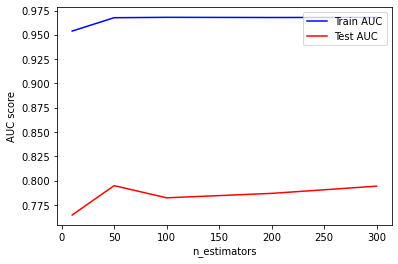

In [19]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import metrics

n_estimators = [10, 50, 100, 200, 300]
train_results = []
test_results = []
for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator) #n_jobs=-1)
    rf.fit(X_train, y_train.values.ravel())
    train_pred = rf.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_train.values.ravel(), train_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1 = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
line2 = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
plt.legend(loc="upper right")
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

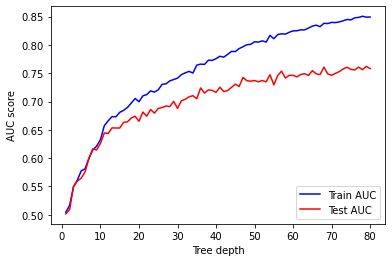

In [20]:
max_depths = np.linspace(1, 80, 80, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
    rf.fit(X_train, y_train.values.ravel())
    train_pred = rf.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_train.values.ravel(), train_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D

line1 = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2 = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(loc="lower right")
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

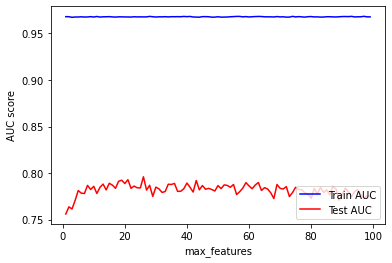

In [21]:
max_features = list(range(1,100))
train_results = []
test_results = []
for max_feature in max_features:
    rf = RandomForestClassifier(max_features=max_feature)
    rf.fit(X_train, y_train.values.ravel())
    train_pred = rf.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_train.values.ravel(), train_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D

line1 = plt.plot(max_features, train_results, 'b', label='Train AUC')
line2 = plt.plot(max_features, test_results, 'r', label='Test AUC')
plt.legend(loc="lower right")
plt.ylabel('AUC score')
plt.xlabel('max_features')
plt.show()

As it can be seen:
- n_estimators at 300 produced the highest possible AUC score, which will be chosen.
- max_depth could be tested at 50, as further increase seems to not improve the score significantly.
- max_features We see that the model overfits for large values. The trees perfectly predicts all of the train data, however, it fails to generalize the findings for new data.

Next, these parameters will be tested in the model below.

In [22]:
%%time
Model3 = RandomForestClassifier(random_state=0, n_estimators=300, max_depth=50)
Model3.fit(X_train, y_train.values.ravel())
y_pred3 = Model3.predict(X_test)

print("Acuracy", accuracy_score(y_test, y_pred3))
print("Macro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred3, average='macro'))
print("Micro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred3, average='micro'))
print("Weighted precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred3, average='weighted'))

Acuracy 0.7714663143989432
Macro precision_recall_fscore_support
(0.8028586400679425, 0.7399121111922246, 0.7459283071652094, None)
Micro precision_recall_fscore_support
(0.7714663143989432, 0.7714663143989432, 0.7714663143989433, None)
Weighted precision_recall_fscore_support
(0.7925104773127876, 0.7714663143989432, 0.7585909024186024, None)
Wall time: 2.41 s


In [23]:
# Model Evaluation metrics 
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred3)))
print('Precision Score : ' + str(precision_score(y_test,y_pred3)))
print('Recall Score : ' + str(recall_score(y_test,y_pred3)))
print('F1 Score : ' + str(f1_score(y_test,y_pred3)))

#Logistic Regression Classifier Confusion matrix
from sklearn.metrics import confusion_matrix
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred3)))

Accuracy Score : 0.7714663143989432
Precision Score : 0.8686868686868687
Recall Score : 0.5391849529780565
F1 Score : 0.665377176015474
Confusion Matrix : 
[[412  26]
 [147 172]]


### Apply GridSearchCV and compare the results.

In [25]:
%%time
#Grid Search
clf3 = RandomForestClassifier()


# Create the parameter grid based on the results of random search 
param_grid3 = {
    
    'n_estimators': [10, 50, 100, 200, 300]
}


grid_clf_acc3 = GridSearchCV(clf3, param_grid = param_grid3,scoring = 'recall')
grid_clf_acc3.fit(X_train, y_train.values.ravel())

#Predict values based on new parameters
y_pred_acc3 = grid_clf_acc3.predict(X_test)

# New Model Evaluation metrics 
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_acc3)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_acc3)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_acc3)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_acc3)))

#Confusion matrix
confusion_matrix(y_test,y_pred_acc3)

result3 = grid_clf_acc3.fit(X_train, y_train.values.ravel())
print('Best Score: %s' % result3.best_score_)
print('Best Hyperparameters: %s' % result3.best_params_)

Accuracy Score : 0.7899603698811096
Precision Score : 0.7580645161290323
Recall Score : 0.7366771159874608
F1 Score : 0.7472178060413354
Best Score: 0.7090049881858755
Best Hyperparameters: {'n_estimators': 300}
Wall time: 3min 56s


In [26]:
%%time
#Grid Search
clf4 = RandomForestClassifier()


# Create the parameter grid based on the results of random search 
param_grid4 = {
    
    'n_estimators': [10, 50, 100, 200, 300]
}


grid_clf_acc4 = GridSearchCV(clf4, param_grid = param_grid4,scoring = 'recall')
grid_clf_acc4.fit(X_train, y_train.values.ravel())

#Predict values based on new parameters
y_pred_acc4 = grid_clf_acc4.predict(X_test)

# New Model Evaluation metrics 
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_acc4)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_acc4)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_acc4)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_acc4)))

#Confusion matrix
confusion_matrix(y_test,y_pred_acc4)

result4 = grid_clf_acc4.fit(X_train, y_train.values.ravel())
print('Best Score: %s' % result4.best_score_)
print('Best Hyperparameters: %s' % result4.best_params_)

Accuracy Score : 0.7965653896961691
Precision Score : 0.7687296416938111
Recall Score : 0.7398119122257053
F1 Score : 0.7539936102236422
Best Score: 0.7110551034100523
Best Hyperparameters: {'n_estimators': 300}
Wall time: 4min 3s


It can be seen that the GridSearchCV performed better parameters optimization, than AUC. Probably beacuse more optimal max_depth was found than the range setup in a manual analysis.

## Error Analysis

To understand what type of tweets are usually misclassified, they will be first extracted, processed and visualized with wordcloud to observe any patterns there.

In [27]:
#Extracting the miscalssified data

y_pred_acc3_df = pd.DataFrame(y_pred_acc3)

y_misclass=y_test
y_misclass["pred"]=y_pred_acc3_df[0].to_numpy()
y_misclass["text"]=data_processed["text"]
pd.set_option('display.max_colwidth', None)
y_misclass[y_misclass["target"]!=y_misclass["pred"]].head(30)

<ipython-input-27-79c32bfd7bbc>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_misclass["pred"]=y_pred_acc3_df[0].to_numpy()
<ipython-input-27-79c32bfd7bbc>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_misclass["text"]=data_processed["text"]


,target,pred,text
1763,1,0,tells of the tragic midmorning collision which claimed the life of a young man riding a motorcycle
6756,0,1,im a tornado looking for a soul to take
6324,1,0,show me a picture of it
3187,1,0,yo forreal we need to have like an emergency action plan incase donald trump becomes president whipe that lil baby
3844,0,1,just added some more fire to the flames for saturday rick wonder will be spinning a guest set along with chachi
4224,1,0,from recycling to only using nonhazardous chemicals holland continually strives to maintain an ecofriendly existence
4037,0,1,usfs an acronym for united states fire service
4414,1,0,hot funtenna hijacking computers to send data as sound waves black hat
1758,1,0,westminister sr w knott st trfc collisionno inj
2269,1,0,rand pauls debate strategy demolish some other bad ideas out there or point out maybe that there are some em


In [28]:
m=y_misclass[y_misclass["target"]!=y_misclass["pred"]]
m.head()
m.reset_index(drop=True, inplace=True)
m.head()

,target,pred,text
0,1,0,tells of the tragic midmorning collision which claimed the life of a young man riding a motorcycle
1,0,1,im a tornado looking for a soul to take
2,1,0,show me a picture of it
3,1,0,yo forreal we need to have like an emergency action plan incase donald trump becomes president whipe that lil baby
4,0,1,just added some more fire to the flames for saturday rick wonder will be spinning a guest set along with chachi


In [29]:
#Removing stopwords and lemmatizing it
m['tweet_without_stopwords'] = m['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

nltk.download('wordnet')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

m['text_lemmatized'] = m.tweet_without_stopwords.apply(lemmatize_text)
m['text_lemmatized'] = m['text_lemmatized'].apply(lambda x: " ".join(x)) #convert list to one string

m

<ipython-input-29-0a964ba9c9df>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m['tweet_without_stopwords'] = m['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
<ipython-input-29-0a964ba9c9df>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m['text_lemmatized'] = m.tweet_without_stopwords.apply(lemmatize_text)
<ipyth

,target,pred,text,tweet_without_stopwords,text_lemmatized
0,1,0,tells of the tragic midmorning collision which claimed the life of a young man riding a motorcycle,tells tragic midmorning collision claimed life young man riding motorcycle,tell tragic midmorning collision claimed life young man riding motorcycle
1,0,1,im a tornado looking for a soul to take,im tornado looking soul take,im tornado looking soul take
2,1,0,show me a picture of it,show picture,show picture
3,1,0,yo forreal we need to have like an emergency action plan incase donald trump becomes president whipe that lil baby,yo forreal need like emergency action plan incase donald trump becomes president whipe lil baby,yo forreal need like emergency action plan incase donald trump becomes president whipe lil baby
4,0,1,just added some more fire to the flames for saturday rick wonder will be spinning a guest set along with chachi,added fire flames saturday rick wonder spinning guest set along chachi,added fire flame saturday rick wonder spinning guest set along chachi
...,...,...,...,...,...
154,1,0,indeed i am fully aware of that battle i support you in that fight,indeed fully aware battle support fight,indeed fully aware battle support fight
155,1,0,i agree with to get out amp vote look at devastation caused firstnations idlenomore cndpoli yyj,agree get amp vote look devastation caused firstnations idlenomore cndpoli yyj,agree get amp vote look devastation caused firstnations idlenomore cndpoli yyj
156,0,1,this sale and demolition trend near metrotown is sure resulting in some poorly maintained apartments burnaby changefortheworse,sale demolition trend near metrotown sure resulting poorly maintained apartments burnaby changefortheworse,sale demolition trend near metrotown sure resulting poorly maintained apartment burnaby changefortheworse
157,1,0,i feel like a tornado,feel like tornado,feel like tornado


In [30]:
#Applying Bag of words to vectorize it
bow_vectorizer3 = CountVectorizer(dtype=np.float32,
                                 strip_accents='unicode',
                                 tokenizer=word_tokenize,
                                 ngram_range=(1,1), # keep the unigram
                                 analyzer='word') # feature should be made of word n-gram

In [31]:
bow_features3 = pd.DataFrame(bow_vectorizer3.fit_transform(m['text_lemmatized']).toarray(), columns=sorted(bow_vectorizer3.vocabulary_))
bow_features3

,aba,abbott,accepts,accident,account,acronym,across,action,added,affliction,...,yay,yemen,yo,young,youre,youve,yyc,yyj,zimmer,zotar
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
#Importing the required libraries for wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [33]:
# create index arrays for filtering rows based on the target
disaster_text_row_index = m.query("target == 1").index
non_disaster_text_row_index = m.query("target == 0").index

In [34]:
# create a dictionary of term frequency
def create_term_frequency_count(term_features):
    word_count = term_features.sum()
    return dict(zip(word_count.index, word_count.values))

# function for create wordcloud from term frequency dictionary
def create_word_cloud(category_count, title=""):
    wordcloud = WordCloud(background_color="black",
                          random_state=1, # reproducible wordcloud
                          width=1600, 
                          height=800).generate_from_frequencies(category_count)
    plt.figure(figsize=(10,10));
    plt.imshow(wordcloud)
    plt.title(label=title, fontdict={"fontsize": 30})
    plt.axis("off")
    plt.show();

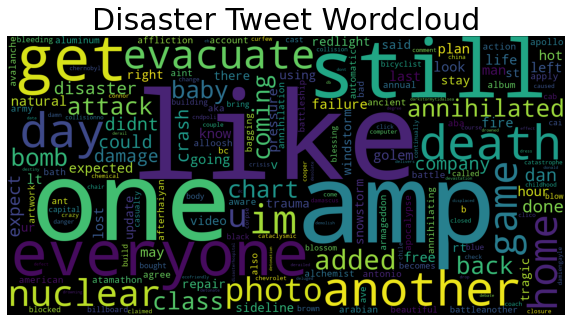

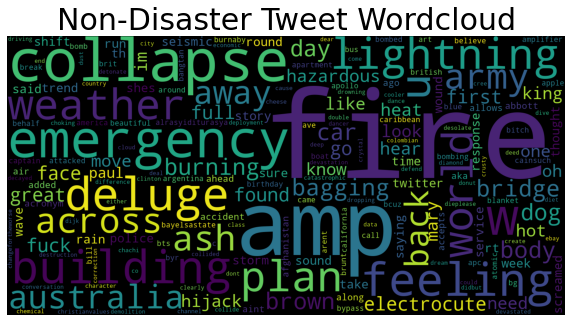

In [35]:
# create term frequency dictionary and use it for plotting the word cloud
category_count = create_term_frequency_count(bow_features3.iloc[disaster_text_row_index])
create_word_cloud(category_count, title="Disaster Tweet Wordcloud")


category_count = create_term_frequency_count(bow_features3.iloc[non_disaster_text_row_index])
create_word_cloud(category_count, title="Non-Disaster Tweet Wordcloud")

# Summary

* It can be seen that the GridSearchCV has better evaluation parameters than manual way. Most probably it is because more optimal number of max_depth was found than the range setup in a AUC analysis. 
* The best recall was obtained with 0.739 score and n_estimators:300 (gridsearchcv output). This was the result with preprocessing of the data (basic punctuation stopwords removal, lemmatizing, etc.), which highlights the importance of proper for each model preprocessing techniques. 
* The error analysis of misclassified tweets clearly shows why the misclassification happens and why it is so difficult for a model to analyze these tweets. 
* By looking at the wordcloud of disaster tweets, the main words that come up are: like, one, amp, another, still, get. The words that indicate more disaster like: death, evacuate, attack are less frequent, which makes it difficult for a model to classify the tweets correctly and produce less false negatives.
* Looking at the wordcloud of non-disaster tweets, the main words that come up are: fire, emergency, collapse, lightning, deluge, amp. It is clear that these are the words usually associated with the disaster and model most probably has been used them as keywords for classifying them as disasters during training. People use these words metaphorically sometimes, especially in tweeter, which is informal language. For example, people can tweet "fire" with a meaning of something being "great". However, for the model it would be difficult to diffefentiate that from the real disaster case, as usually there is a little context included in a tweet. Thus, more false positives are produced.
* Also it was observed that the word "amp" was very frequent in both disaster and non-disaster tweets, which complicates classification in these two categories. So, removing this word might improve the model performance.

# Further recommendations

The further steps can be planned to test in the future:
* It would be interesting to observe the effect of removing the abbreviations and short forms of the text or transforming them to one base. As discussed, tweeter has mainly unofficial language so there are many abbrevaitaions, contractions, and short versions of words, like "I have" = "I've"; "b/c" " = "because".
* Also it might be good to remove the most common typos.
* As well as remove emojis or convert them to numbers/codes.
* Plus, I would be interested in testing another models and techniques like support vector machines, neural networks.
* It would be also nice to introduce in the code the interactive part, where you can enter the potential tweet and the code will tell you whether it is classified as a disaster or not.